In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services



In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 8.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


### Inclusion of all the necessary libraries

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import sklearn

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy import stats

import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Cleaning functions



In [4]:
#data cleaning
def str2float(x):
    if type(x)==str:
        return eval(x)
    else:
        return x

In [5]:
def data_cleaning(df,clustering=False):
    '''
    Replace strings 
    Replace missing values to np.nan - data taken from the excel provided.
    Replace na with mean
    LNR set as index
    Removal of outliers
    Cleaning columns if it doesn't have enough data
    '''
    print(df.shape)
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
        try:
            df[column] = df[column].replace(["X","XX"],np.nan)
        except:
            pass
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column]=df[column].apply(str2float)
    
    #change the catergory columns into numbertraining
    for column in ["CAMEO_DEU_2015","D19_LETZTER_KAUF_BRANCHE","OST_WEST_KZ"]:
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        
    #extract the time,and keep the year   
    df["EINGEFUEGT_AM"]=pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year
  
    temp_col = ["ALTERSKATEGORIE_GROB","ANREDE_KZ","GEBAEUDETYP","GEOSCORE_KLS7","HAUSHALTSSTRUKTUR",
            'HH_EINKOMMEN_SCORE',"KBA05_BAUMAX","KBA05_GBZ","KKK","NATIONALITAET_KZ","PRAEGENDE_JUGENDJAHRE",
            "REGIOTYP","TITEL_KZ","WOHNDAUER_2008","WACHSTUMSGEBIET_NB","W_KEIT_KIND_HH"]
    for column in temp_col:
        try:
            df[column] = df[column].replace([0,-1],np.nan)
        except:
            pass
        
    temp_col= ['KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_AUTOQUOT',
             'KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_HERST1',
             'KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5','KBA05_HERSTTEMP','KBA05_KRSAQUOT',
             'KBA05_KRSHERST1','KBA05_KRSHERST2','KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
             'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ','KBA05_MAXHERST',
             'KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2','KBA05_MOD3','KBA05_MOD4','KBA05_MOD8',
             'KBA05_MODTEMP','KBA05_MOTOR','KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
             'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9','KBA05_VORB0',
             'KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2','KBA05_ZUL3','KBA05_ZUL4','RELAT_AB',
             'SEMIO_DOM',
             'SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST','SEMIO_MAT',
             'SEMIO_PFLICHT',
             'SEMIO_RAT','SEMIO_REL','SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','ZABEOTYP']
    for column in temp_col:
        try:
            df[column] = df[column].replace([9,-1],np.nan)
        except:
            pass

    for column in df.columns.values:
        try:
            df[column] = df[column].replace([-1],np.nan)
        except:
            pass
        
    df['GEBURTSJAHR'] = df["GEBURTSJAHR"].replace([0],np.nan)

    #get rid of the rows which have the age is 0 which corresponds to NaN
    df = df.drop(['Unnamed: 0'],axis = 1)
    if clustering:
      corr_matrix = df.corr().abs()
      limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
      drop_col = [column for column in limit.columns if any(limit[column] > 0.7)]
      df = df.drop(drop_col,axis =1)
    
    df = df.set_index('LNR')
    
    df_columns = list(df.columns.values)
    
    imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns = df_columns)
    print(df.shape)
    
    return df

## Part 2: Supervised Learning Model


Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

**Loading and Cleaning Dataset**

In [9]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [11]:
mailout_train_cleaned = data_cleaning(mailout_train,False)

(42962, 368)
(42962, 366)


In [12]:
X = mailout_train_cleaned.drop('RESPONSE',axis =1)
y = mailout_train_cleaned['RESPONSE']

In [13]:
print(mailout_train_cleaned.shape)
print(y.shape)

(42962, 366)
(42962,)


In [14]:
mailout_train_cleaned.head(5), y.head(5)

(   AGER_TYP  AKT_DAT_KL  ALTER_HH  ...  RESPONSE  ANREDE_KZ  ALTERSKATEGORIE_GROB
 0       2.0         1.0       8.0  ...       0.0        2.0                   4.0
 1       1.0         4.0      13.0  ...       0.0        2.0                   3.0
 2       1.0         1.0       9.0  ...       0.0        1.0                   4.0
 3       2.0         1.0       6.0  ...       0.0        2.0                   4.0
 4       2.0         1.0       9.0  ...       0.0        1.0                   3.0
 
 [5 rows x 366 columns], 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: RESPONSE, dtype: float64)

**Function for plotting learning curve** - taken from sklearn site


In [15]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
    title : str
        Title for the chart.
    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.
    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.
    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.
    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [16]:
#initialise 
classifier_1_XGB = XGBClassifier(objective = 'binary:logistic',random_state= 123)
classifier_2_RF = RandomForestClassifier(random_state=123)
classifier_3_Ada = AdaBoostClassifier(random_state=123)
classifier_4_DT = DecisionTreeClassifier(random_state=123)

In [17]:
cv = StratifiedKFold(n_splits=4)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

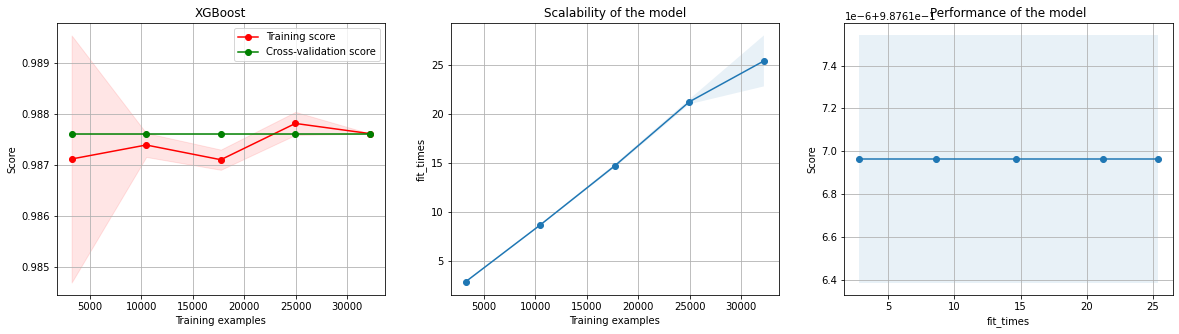

In [18]:
plot_learning_curve(classifier_1_XGB,"XGBoost",X,y,cv=cv,ylim=None,n_jobs =2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

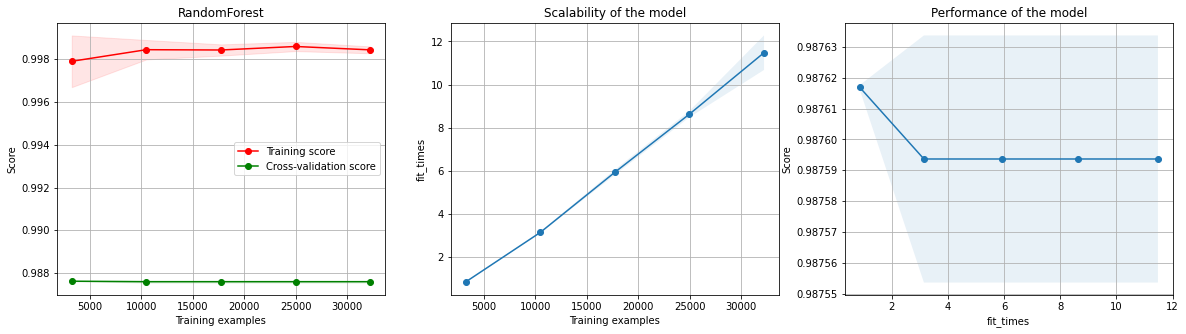

In [19]:
plot_learning_curve(classifier_2_RF,"RandomForest",X.values,y.values,cv=cv,ylim=None,n_jobs =2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

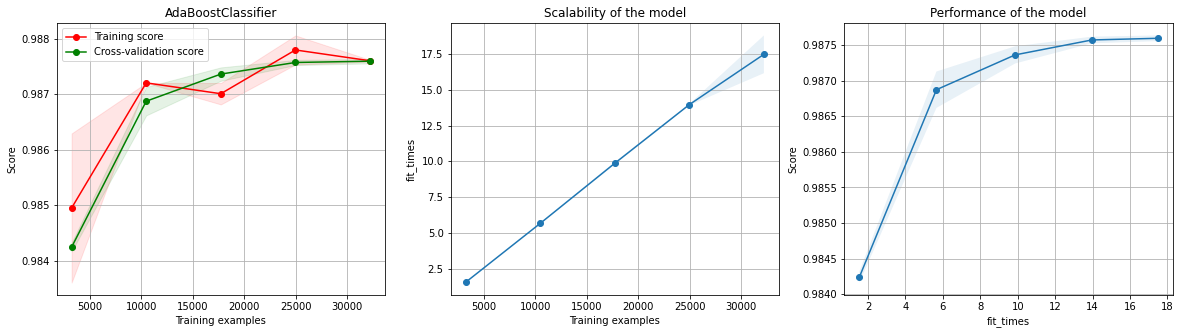

In [20]:
plot_learning_curve(classifier_3_Ada,"AdaBoostClassifier",X.values,y.values,cv=cv,ylim=None,n_jobs =2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

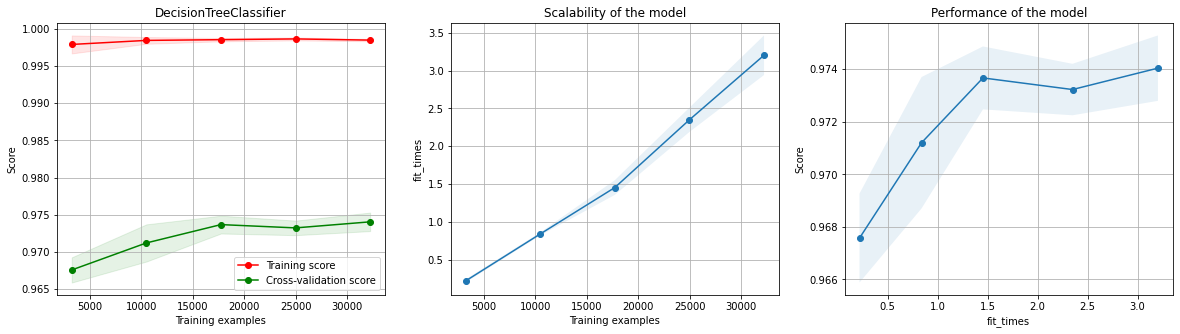

In [21]:
plot_learning_curve(classifier_4_DT,"DecisionTreeClassifier",X.values,y.values,cv=cv,ylim=None,n_jobs =2)

**Hyperparameter Tuning**

In [22]:
classifier_1_XGB = XGBClassifier(objective='binary:logistic',learning_rate=0.01,
                                 n_estimators=500,max_depth=4,min_child_weight=3,
                                 gamma=0.2,subsample=0.8,random_state=123,
                                 colsample_bytree=0.8,scale_pos_weight=1,n_jobs=-1)

In [23]:
regressor = cross_val_score(classifier_1_XGB,X,y,cv=cv,n_jobs=-1)
print(regressor.mean())

0.9876169638016635


In [24]:
classifier_1_XGB.fit(X,y)

XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=500, n_jobs=-1, random_state=123,
              subsample=0.8)



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [25]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [27]:
X_test = data_cleaning(mailout_test)
X_test.head()

(42833, 367)
(42833, 365)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,7.0,18.0,18.0,17.0,13.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,6.0,2.0,13.0,5.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,3.0,6.0,0.0,...,3.0,4.0,5.0,2.0,5.0,1.0,3.0,3.0,4.0,2.0,3.0,6.0,7.0,1.0,1.0,1.0,2.0,6.0,1.0,7.0,3.0,0.0,3.0,1.0,2.0,5.0,0.0,23.0,1.0,1.0,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3.0,1.0,4.0
1,2.0,1.0,0.0,18.0,18.0,17.0,13.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,18.0,5.0,31.0,1.0,5.0,2.0,2.0,5.0,5.0,4.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,6.0,0.0,...,4.0,5.0,5.0,1.0,5.0,1.0,3.0,7.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,3.0,6.0,1.0,6.0,2.0,0.0,3.0,1.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3.0,1.0,4.0
2,2.0,9.0,16.0,18.0,18.0,17.0,13.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,30.0,7.0,41.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,...,6.0,5.0,5.0,2.0,5.0,1.0,5.0,7.0,1.0,6.0,4.0,2.0,7.0,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,0.0,3.0,1.0,1.0,5.0,1.0,15.0,1.0,1.0,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3.0,2.0,4.0
3,2.0,7.0,0.0,18.0,18.0,17.0,13.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,6.0,2.0,13.0,4.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,5.0,1.0,3.0,1.0,5.0,7.0,1.0,6.0,7.0,2.0,7.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,0.0,3.0,1.0,2.0,5.0,0.0,10.0,2.0,1.0,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3.0,2.0,4.0
4,1.0,1.0,21.0,18.0,18.0,17.0,13.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,18.0,5.0,31.0,6.0,1.0,3.0,2.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,2.0,2.0,0.0,8.0,2.0,10.0,6.0,6.0,6.0,5.0,...,4.0,2.0,3.0,3.0,2.0,3.0,6.0,7.0,2.0,5.0,4.0,2.0,5.0,2.0,3.0,3.0,2.0,5.0,3.0,3.0,3.0,0.0,2.0,1.0,5.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4.0,2.0,4.0


In [28]:
X.shape

(42962, 365)

In [29]:
y_test = classifier_1_XGB.predict_proba(X_test)

In [30]:
y_test[:,1]

array([0.03423661, 0.03254589, 0.00597371, ..., 0.02657681, 0.02532507,
       0.02344348], dtype=float32)

In [31]:
pd.DataFrame(index=mailout_test.LNR, data = y_test[:,1],columns=['RESPONSE']).to_csv("kaggle_predictions.csv")

## Grabbed 24th place in leadershipboard as on 20-09-2020
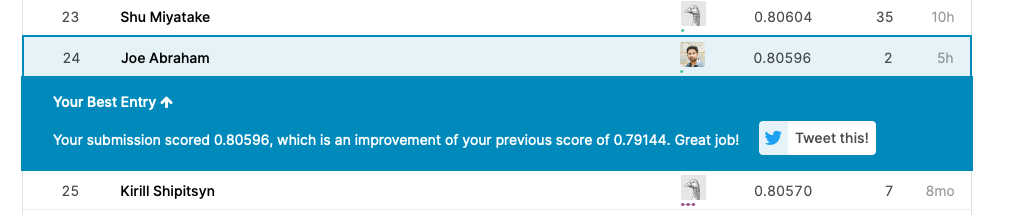